In [1]:
from utils import *
from fastai2.vision.widgets import *

ModuleNotFoundError: No module named 'utils'

In [2]:
key = 'dc977f916e294fefbe3afb41de4f58ef'

In [3]:
search_images_bing

<function utils.search_images_bing(key, term, min_sz=128)>

In [4]:
results = search_images_bing(key, 'abominable snowman')
ims = results.attrgot('content_url')
len(ims)

150

In [5]:
ims = ['https://www.bing.com/images/search?view=detailV2&ccid=G62ai2Tt&id=473FAFD5578EB2BDB185E886F75518FC99C23BBE&thid=OIP.G62ai2Tt0qTgAERnOZTe2AHaHY&mediaurl=https%3a%2f%2fc2.staticflickr.com%2f4%2f3235%2f3119122666_6d11569a25_b.jpg&exph=1020&expw=1024&q=abominable+snowman&simid=608024415023466259&selectedIndex=0']

In [6]:
dest = 'images/abominable.jpg'
download_url(ims[0], dest)

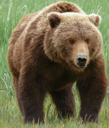

In [7]:
im = Image.open(dest)
im.to_thumb(64,64)

In [8]:
snowperson_types = 'abominable','frozen'
path = Path('snowpeople')

In [10]:
if not path.exists():
    path.mkdir()
    for o in snowperson_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} snowman')
        download_images(dest, urls=results.attrgot('content_url'))

In [11]:
fns = get_image_files(path)
fns

(#197) [Path('snowpeople/abominable/00000002.jpg'),Path('snowpeople/abominable/00000001.jpg'),Path('snowpeople/abominable/00000004.jpg'),Path('snowpeople/abominable/00000006.jpg'),Path('snowpeople/abominable/00000007.jpg'),Path('snowpeople/abominable/00000005.jpg'),Path('snowpeople/abominable/00000010.jpg'),Path('snowpeople/abominable/00000013.jpg'),Path('snowpeople/abominable/00000009.jpg'),Path('snowpeople/abominable/00000011.jpg')...]

In [12]:
# check for corrupt images
failed = verify_images(fns)
failed

/opt/conda/envs/fastai/lib/python3.7/site-packages/PIL/Image.py:2860: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


(#5) [Path('snowpeople/abominable/00000008.jpg'),Path('snowpeople/abominable/00000072.jpg'),Path('snowpeople/abominable/00000118.jpg'),Path('snowpeople/abominable/00000149.png'),Path('snowpeople/frozen/00000030.png')]

In [13]:
# remove corrupt images
'''verify_images returns an object of type L, which includes the map method. 
This calls the passed function on each element of the collection.'''
failed.map(Path.unlink);

In [14]:
snowpeople = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = snowpeople.dataloaders(path)

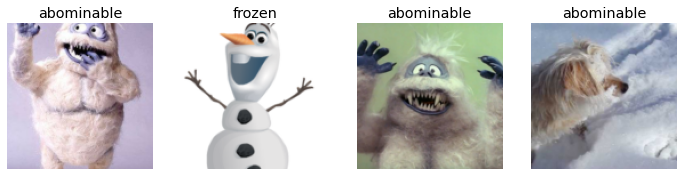

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

In [19]:
# Train your model and use it to clean the data
snowpeople = snowpeople.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = snowpeople.dataloaders(path)

In [20]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.168281,1.019941,0.456140,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.481155,0.916555,0.491228,00:04
1,0.428900,0.993212,0.473684,00:04
2,0.363921,0.673532,0.368421,00:05
3,0.293071,0.337547,0.157895,00:05


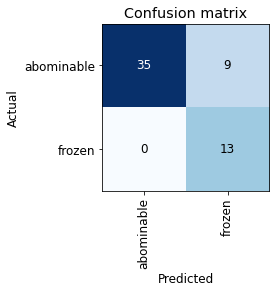

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

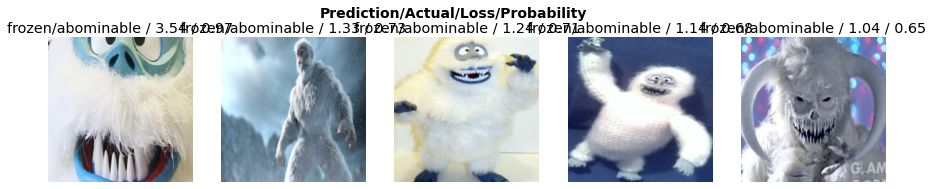

In [22]:
interp.plot_top_losses(5, nrows=1)

In [23]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [27]:
learn.export()

In [28]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [29]:
learn_inf = load_learner(path/'export.pkl')

In [30]:
learn_inf.predict('images/abominable.jpg')

('abominable', tensor(0), tensor([0.9984, 0.0016]))

In [31]:
learn_inf.dls.vocab

(#2) ['abominable','frozen']

In [34]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [36]:
img = PILImage.create(btn_upload.data[-1])

In [37]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [40]:
pred,pred_idx,probs = learn_inf.predict(img)

In [41]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: frozen; Probability: 0.9950')

In [42]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [43]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [44]:
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [45]:
VBox([widgets.Label('Select your snowperson!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [47]:
# Turning the notebook into a real web app
!pip install voila
!jupyter serverextension enable voila --sys-prefix

Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.1.21 OK
